In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
from poly_utils import get_markets, PLATFORM_WALLETS

pl.Config.set_tbl_rows(25)
pl.Config.set_tbl_cols(-1)  # Show all columns
cfg = pl.Config.set_tbl_width_chars(1000)  # Wider display


In [2]:
markets_df = get_markets()

Loaded 159307 markets from markets.csv
Combined total: 158760 unique markets (sorted by createdAt)


In [3]:
df = pl.scan_csv("processed/trades.csv").collect(streaming=True)

df = df.with_columns(
    pl.col("timestamp").str.to_datetime().alias("timestamp")
)

In [4]:
# Count unique makers per taker transaction
taker_maker_counts = (
    df
    .group_by("transactionHash")
    .agg(
        pl.n_unique("maker").alias("num_makers_matched"),
        pl.col("usd_amount").sum().alias("total_volume")
    )
)

In [6]:
print(f"Average makers matched per taker order: {taker_maker_counts['num_makers_matched'].mean():.2f}")


Average makers matched per taker order: 2.21


In [7]:
print(f"Median makers matched per taker order: {taker_maker_counts['num_makers_matched'].median():.2f}")

Median makers matched per taker order: 2.00


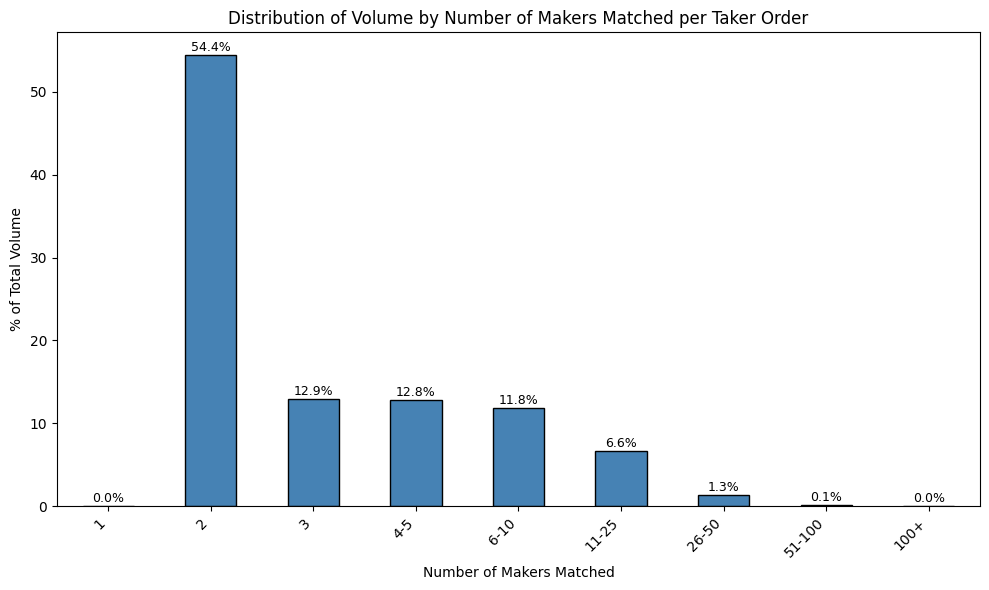

In [8]:
import numpy as np

# Create bins for number of makers matched
bins = [0, 1, 2, 3, 5, 10, 25, 50, 100, np.inf]
labels = ['1', '2', '3', '4-5', '6-10', '11-25', '26-50', '51-100', '100+']

# Convert to pandas for easier binning
taker_pd = taker_maker_counts.to_pandas()
taker_pd['bin'] = pd.cut(taker_pd['num_makers_matched'], bins=bins, labels=labels)

# Group by bin and sum volume
volume_by_bin = taker_pd.groupby('bin', observed=True)['total_volume'].sum()
volume_pct = (volume_by_bin / volume_by_bin.sum() * 100)

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
volume_pct.plot(kind='bar', ax=ax, color='steelblue', edgecolor='black')
ax.set_xlabel('Number of Makers Matched')
ax.set_ylabel('% of Total Volume')
ax.set_title('Distribution of Volume by Number of Makers Matched per Taker Order')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

# Add percentage labels on bars
for i, v in enumerate(volume_pct):
    ax.text(i, v + 0.5, f'{v:.1f}%', ha='center', fontsize=9)

plt.tight_layout()
plt.show()

In [10]:
volume_pct

bin
1          0.039529
2         54.434720
3         12.897801
4-5       12.770219
6-10      11.796030
11-25      6.623493
26-50      1.315967
51-100     0.122184
100+       0.000056
Name: total_volume, dtype: float64

In [4]:
USERS = {
    'domah': '0x9d84ce0306f8551e02efef1680475fc0f1dc1344',
    '50pence': '0x3cf3e8d5427aed066a7a5926980600f6c3cf87b3',
    'fhantom': '0x6356fb47642a028bc09df92023c35a21a0b41885',
    'car': '0x7c3db723f1d4d8cb9c550095203b686cb11e5c6b',
    'theo4': '0x56687bf447db6ffa42ffe2204a05edaa20f55839',
    'aenews2': '0x44c1dfe43260c94ed4f1d00de2e1f80fb113ebc1'
}

In [5]:
# a easy hack that does a good enough job of determining redemptions

df = df.with_columns(
    pl.col("price")
      .sort_by("timestamp")          # ensure we use the latest trade within each group
      .last()
      .over(["market_id", "nonusdc_side"])
      .alias("last_price")
)

df = df.with_columns(
    last_price = (
        pl.when(pl.col("last_price") > 0.98).then(pl.lit(1.0))
         .when(pl.col("last_price") < 0.02).then(pl.lit(0.0))
         .otherwise(pl.col("last_price"))
    )
)


### This is how polymarket generates its events and this is how you get all trades for a given user. Even if it looks like we are only getting data where the user is a maker, that is not how it works on the contract level. maker shows trades from that users pov including price

In [6]:
trader_df = df.filter((pl.col("maker") == USERS['aenews2']))

In [7]:
trader_df = trader_df[['timestamp', 'market_id', 'maker', 'taker', 'maker_direction', 'nonusdc_side', 'price', 'token_amount', 'usd_amount', 'transactionHash', 'last_price']]
trader_df = trader_df.rename({'maker_direction': 'direction', 'nonusdc_side': 'side'})

In [8]:
trader_df = (
    trader_df
    .group_by(["market_id", "side"])
    .agg(
        # USD volumes
        (pl.when(pl.col("direction") == "BUY").then(pl.col("usd_amount")).otherwise(0.0)).sum().alias("buy_usd"),
        (pl.when(pl.col("direction") == "SELL").then(pl.col("usd_amount")).otherwise(0.0)).sum().alias("sell_usd"),

        # Token volumes
        (pl.when(pl.col("direction") == "BUY").then(pl.col("token_amount")).otherwise(0.0)).sum().alias("buy_tokens"),
        (pl.when(pl.col("direction") == "SELL").then(pl.col("token_amount")).otherwise(0.0)).sum().alias("sell_tokens"),

        # Notionals for VWAPs
        (pl.when(pl.col("direction") == "BUY").then(pl.col("price") * pl.col("token_amount")).otherwise(0.0)).sum().alias("buy_notional"),
        (pl.when(pl.col("direction") == "SELL").then(pl.col("price") * pl.col("token_amount")).otherwise(0.0)).sum().alias("sell_notional"),

        pl.len().alias("trades"),
        pl.col("last_price").last().alias("last_price"),
    )
    .with_columns(
        (pl.col("sell_usd") - pl.col("buy_usd")).alias("cash_pnl_usd"),
        (pl.col("buy_tokens") - pl.col("sell_tokens")).alias("inventory_tokens"),
    )
    .with_columns(
        (pl.col("inventory_tokens") * pl.col("last_price")).alias("unrealized_usd"),
    )
    .with_columns(
        (pl.col("cash_pnl_usd") + pl.col("unrealized_usd")).alias("total_pnl_usd"),
    )
)

In [9]:
trader_df['total_pnl_usd'].sum() #domers total PnL. Checks out within 1% in the UI

1411638.1010985067